# Anticipez les besoins en consommation électrique de bâtiments

**Problématique de la ville de Seattle**  
Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

**Votre mission**  
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

L’objectif est de se passer des relevés de consommation annuels (attention à la fuite de données), mais rien n'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Faire bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mettre en place une évaluation rigoureuse des performances de la régression, et optimiser les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

**Livrables attendus**  
- Un notebook de l'analyse exploratoire mis au propre et annoté.
- Le code (ou un notebook) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
- Un support de présentation pour la soutenance.

**Compétences évaluées**  
- Mettre en place le modèle d'apprentissage supervisé adapté au problème métier
- Évaluer les performances d’un modèle d'apprentissage supervisé
- Adapter les hyperparamètres d'un algorithme d'apprentissage supervisé afin de l'améliorer
- Transformer les variables pertinentes d'un modèle d'apprentissage supervisé

__Techniques__
- ACP: réduction de dimension
- clustering hiérarchique
- knn


# Sommaire

__[I. Chargement et nettoyage des données](#I.-Chargement-et-nettoyage-des-données)__\
[I.1 Descriptions des indicateurs](#I.1-Descriptions-des-indicateurs)\
[I.2 Nettoyage](#I.2-Nettoyage)

__[II. Analyse exploratoire](#II.-Analyse-exploratoire)__\
[II.1 Variables qualitatives et variables quantitatives](#II.1-Variables-qualitatives-et-variables-quantitatives)\
[II.2 Variables quantitatives](#II.2-Variables-quantitatives)\
[II.2.1 Distribution des variables quantitatives](#II.2.1-Distribution-des-variables-quantitatives)\
[II.2.2 outliers](#II.2.2-outliers)\
[II.3 Variables catégorielles](#II.3-Variables-catégorielles)\
[II.3.1 Etude des corrélations](#II.3.1-Etude-des-corrélations)

__[III Régressions linéaires](#III-Régressions-linéaires)__\
[III.1 Régression linéaire simple sur les variables quantitatives](#III.1-Régression-linéaire-simple-sur-les-variables-quantitatives)\
[III.2 Régression linéaire simple avec toutes les variables](#II.4.2-Régression-linéaire-simple-avec-toutes-les-variables)\
__[A suivre: Latitude, Longitude](#A-suivre:-Latitude,-Longitude)__

In [1368]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# I. Chargement et nettoyage des données

## I.1 Descriptions des indicateurs

In [1369]:
data2015 = pd.read_csv("./data/2015-building-energy-benchmarking.csv")
data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [1370]:
indicators = pd.Series(data2015.columns, name="indicators")
indicators

0                                         OSEBuildingID
1                                              DataYear
2                                          BuildingType
3                                   PrimaryPropertyType
4                                          PropertyName
5                         TaxParcelIdentificationNumber
6                                              Location
7                                   CouncilDistrictCode
8                                          Neighborhood
9                                             YearBuilt
10                                    NumberofBuildings
11                                       NumberofFloors
12                                     PropertyGFATotal
13                                   PropertyGFAParking
14                               PropertyGFABuilding(s)
15                            ListOfAllPropertyUseTypes
16                               LargestPropertyUseType
17                            LargestPropertyUse

Maintenant 2016-building-energy-benchmarking

In [1371]:
data2016 = pd.read_csv("./data/2016-building-energy-benchmarking.csv")
indicators_2016 = pd.Series(data2016.columns, name="indicators_2016")
indicators_2016

0                       OSEBuildingID
1                            DataYear
2                        BuildingType
3                 PrimaryPropertyType
4                        PropertyName
5                             Address
6                                City
7                               State
8                             ZipCode
9       TaxParcelIdentificationNumber
10                CouncilDistrictCode
11                       Neighborhood
12                           Latitude
13                          Longitude
14                          YearBuilt
15                  NumberofBuildings
16                     NumberofFloors
17                   PropertyGFATotal
18                 PropertyGFAParking
19             PropertyGFABuilding(s)
20          ListOfAllPropertyUseTypes
21             LargestPropertyUseType
22          LargestPropertyUseTypeGFA
23       SecondLargestPropertyUseType
24    SecondLargestPropertyUseTypeGFA
25        ThirdLargestPropertyUseType
26     Third

In [1372]:
set(indicators_2016.to_numpy()).difference(indicators.to_numpy())

{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

In [1373]:
set(indicators.to_numpy()).difference(set(indicators_2016.to_numpy()))

{'2010 Census Tracts',
 'City Council Districts',
 'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}

#### Indicateurs 2015-building-energy-benchmarking

name | description 
--- | --- |
OSEBuildingID|A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
"BuildingType"|"City of Seattle building type classification."
PrimaryPropertyType|The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
PropertyName|Official or common property name.
TaxParcelIdentificationNumber|Property King County PIN
CouncilDistrictCode|Property City of Seattle council district.
YearBuilt|Year in which a property was constructed or underwent a complete renovation.
PropertyGFATotal|Total building and parking gross floor area.
PropertyGFAParking|Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).
PropertyGFABuilding(s)|Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc.
ENERGYSTARScore|An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.
SiteEUI(kBtu/sf)|Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.
SiteEUIWN(kBtu/sf)|Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
SourceEUI(kBtu/sf)|Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.
SourceEUIWN(kBtu/sf)|Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
SiteEnergyUse(kBtu)|The annual amount of energy consumed by the property from all sources of energy.
SteamUse(kBtu)|The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).
Electricity(kWh)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh.
Electricity(kBtu)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).
NaturalGas(therms)|The annual amount of utility-supplied natural gas consumed by the property, measured in therms.
GHGEmissions(MetricTonsCO2e)|The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.
GHGEmissionsIntensity(kgCO2e/ft2)|Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources



#### Indicateurs 2016-building-energy-benchmarking

name | description 
--- | --- |
TotalGHGEmissions|The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.
GHGEmissionsIntensity|Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources

Plusieurs indicateurs différents.

In [1374]:
data2015.Location.iloc[0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

Il semblerait que les colonnes Latitude Longitude Address City State ZipCode soient contenues dans Location

Dans la table 2015, Zip Codes semble être générées automatiquement - on ne la garde pas dans un premier temps.

In [1375]:
data2015.drop(columns="Zip Codes", inplace=True)

On va donc, dans la table 2015: 
- splitter Location en Latitude, Longitude, Address City State ZipCode
- Retirer Zip Codes

Renommer certaines colonnes pour assurer la correspondance avec 2016, de façon à fusionner les tables
- GHGEmissions(MetricTonsCO2e) (2015) et TotalGHGEmissions (2016) sont en fait les mêmes colonnes
- GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity sont les mêmes colonnes

In [1376]:
from ast import literal_eval # module pour évaluer une expression et renvoyer l'objet correspondant

data2015["Location"] = data2015["Location"].apply(literal_eval) # convertit les str en dict
df = pd.json_normalize(data2015["Location"]) # Normalize semi-structured JSON data into a flat table.
df.human_address = df.human_address.apply(literal_eval)
df2 = pd.json_normalize(df.human_address)
df2.head()

,address,city,state,zip
0,405 OLIVE WAY,SEATTLE,WA,98101
1,724 PINE ST,SEATTLE,WA,98101
2,1900 5TH AVE,SEATTLE,WA,98101
3,620 STEWART ST,SEATTLE,WA,98101
4,401 LENORA ST,SEATTLE,WA,98121


In [1377]:
loc = data2015.columns.get_loc("Location")
data2015.drop(columns="Location", inplace=True)
d = pd.concat([df.drop(columns="human_address"), df2], axis=1) # nouveau dataframe à partir des colonnes extraites

for c in d.columns[::-1]: # Insertion des colonnes dans le df original, une par une
    data2015.insert(loc, c, d[c])

data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,latitude,longitude,address,city,...,GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,...,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,47.61310583,-122.33335756,724 PINE ST,SEATTLE,...,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,...,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,...,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,...,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0


On renomme les colonnes

In [1378]:
data2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                         "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity",
                         "Comment":"Comments",
                         "latitude":"Latitude", 
                         "longitude":"Longitude", 
                         "address":"Address", 
                         "city":"City",
                         "state":"State"}, inplace=True)

In [1379]:
data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Latitude,Longitude,Address,City,...,TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,...,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,47.61310583,-122.33335756,724 PINE ST,SEATTLE,...,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,...,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,...,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,...,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0


In [1380]:
data = pd.concat([data2015, data2016], join="outer")

In [1381]:
data_cols = pd.Series(data.columns, name="data_cols")
data_cols

0                                         OSEBuildingID
1                                              DataYear
2                                          BuildingType
3                                   PrimaryPropertyType
4                                          PropertyName
5                         TaxParcelIdentificationNumber
6                                              Latitude
7                                             Longitude
8                                               Address
9                                                  City
10                                                State
11                                                  zip
12                                  CouncilDistrictCode
13                                         Neighborhood
14                                            YearBuilt
15                                    NumberofBuildings
16                                       NumberofFloors
17                                     PropertyG

## I.2 Nettoyage

<AxesSubplot:>

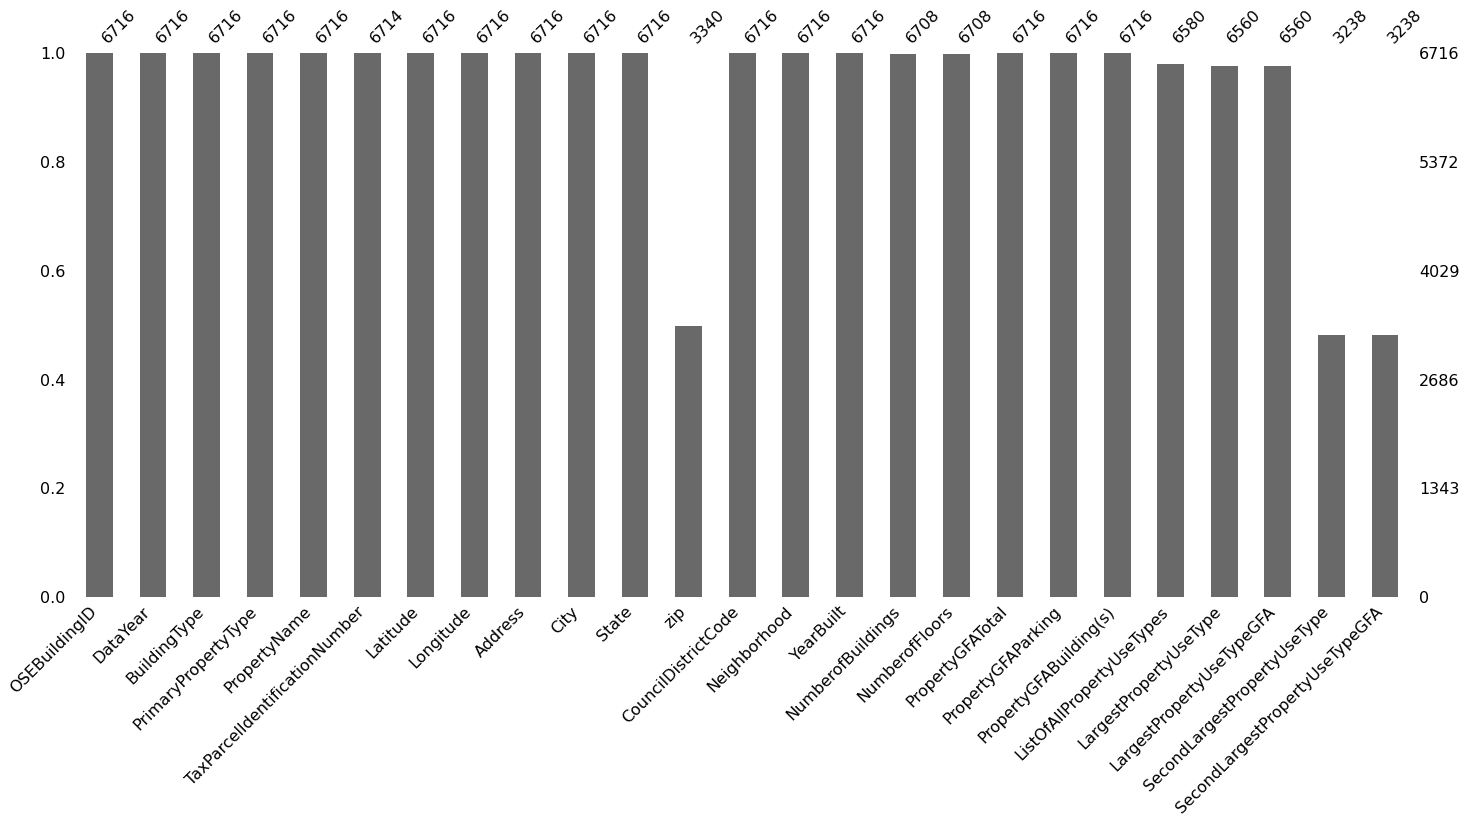

In [1382]:
msno.bar(data[data.columns[:25]])

<AxesSubplot:>

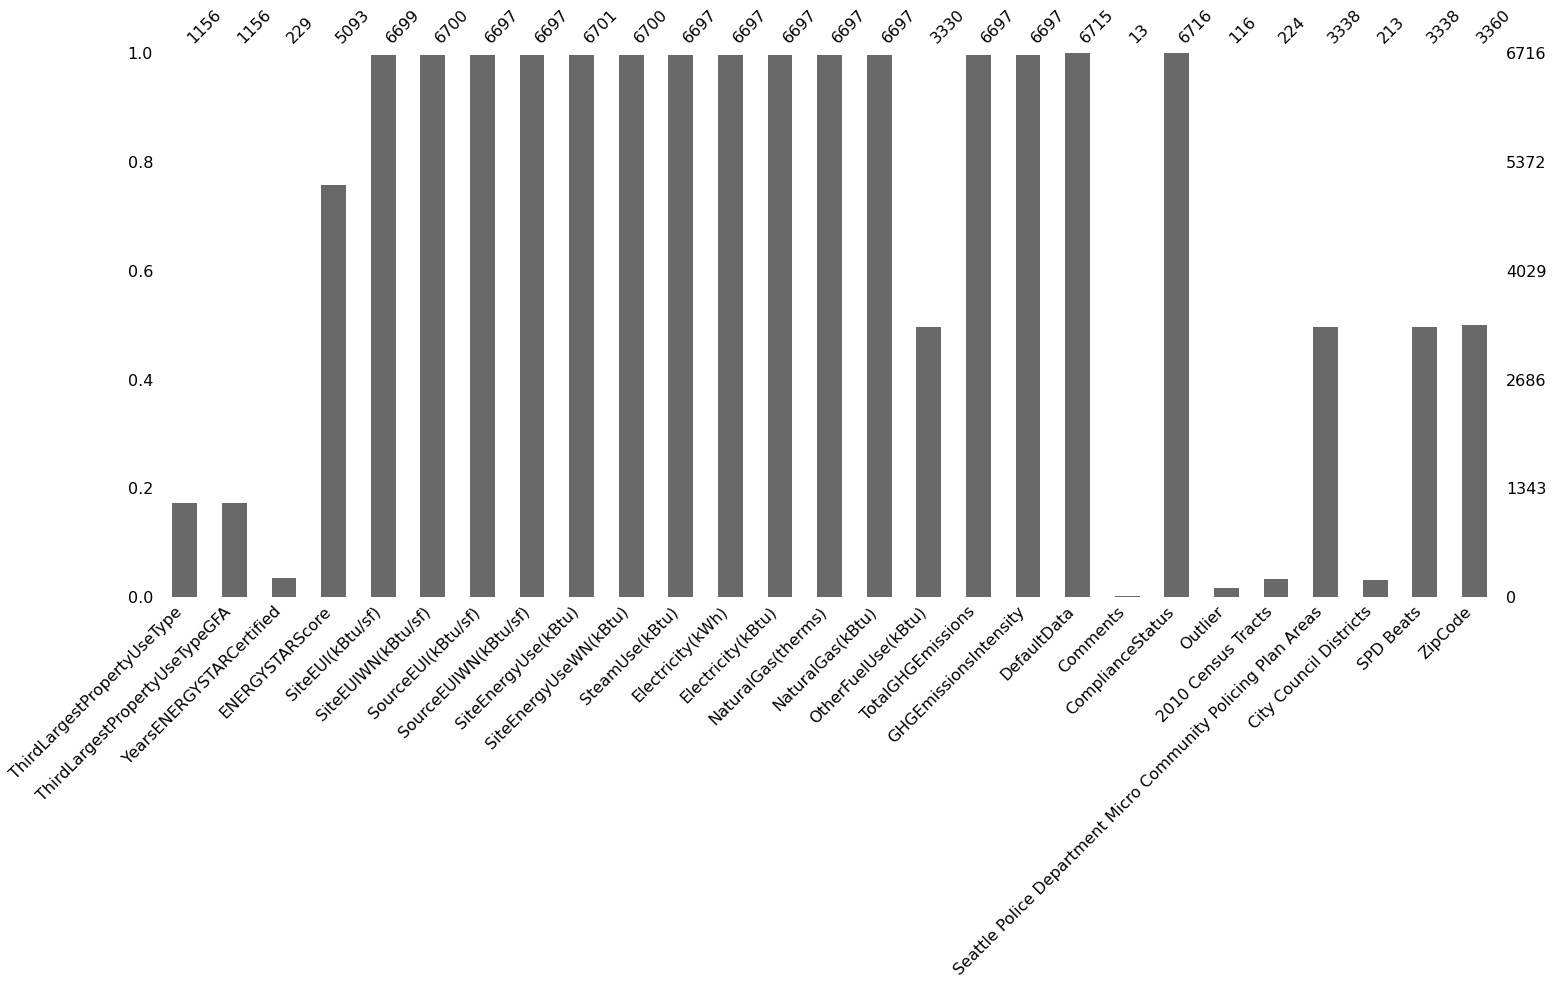

In [1383]:
msno.bar(data[data.columns[25:]])

In [1384]:
missing = data.notna().sum()/data.shape[0]
missing.sort_values(ascending=False)

OSEBuildingID                                                    1.000000
Latitude                                                         1.000000
PropertyGFATotal                                                 1.000000
PropertyGFAParking                                               1.000000
PropertyGFABuilding(s)                                           1.000000
CouncilDistrictCode                                              1.000000
State                                                            1.000000
City                                                             1.000000
Address                                                          1.000000
Longitude                                                        1.000000
Neighborhood                                                     1.000000
YearBuilt                                                        1.000000
DataYear                                                         1.000000
BuildingType                          

<AxesSubplot:>

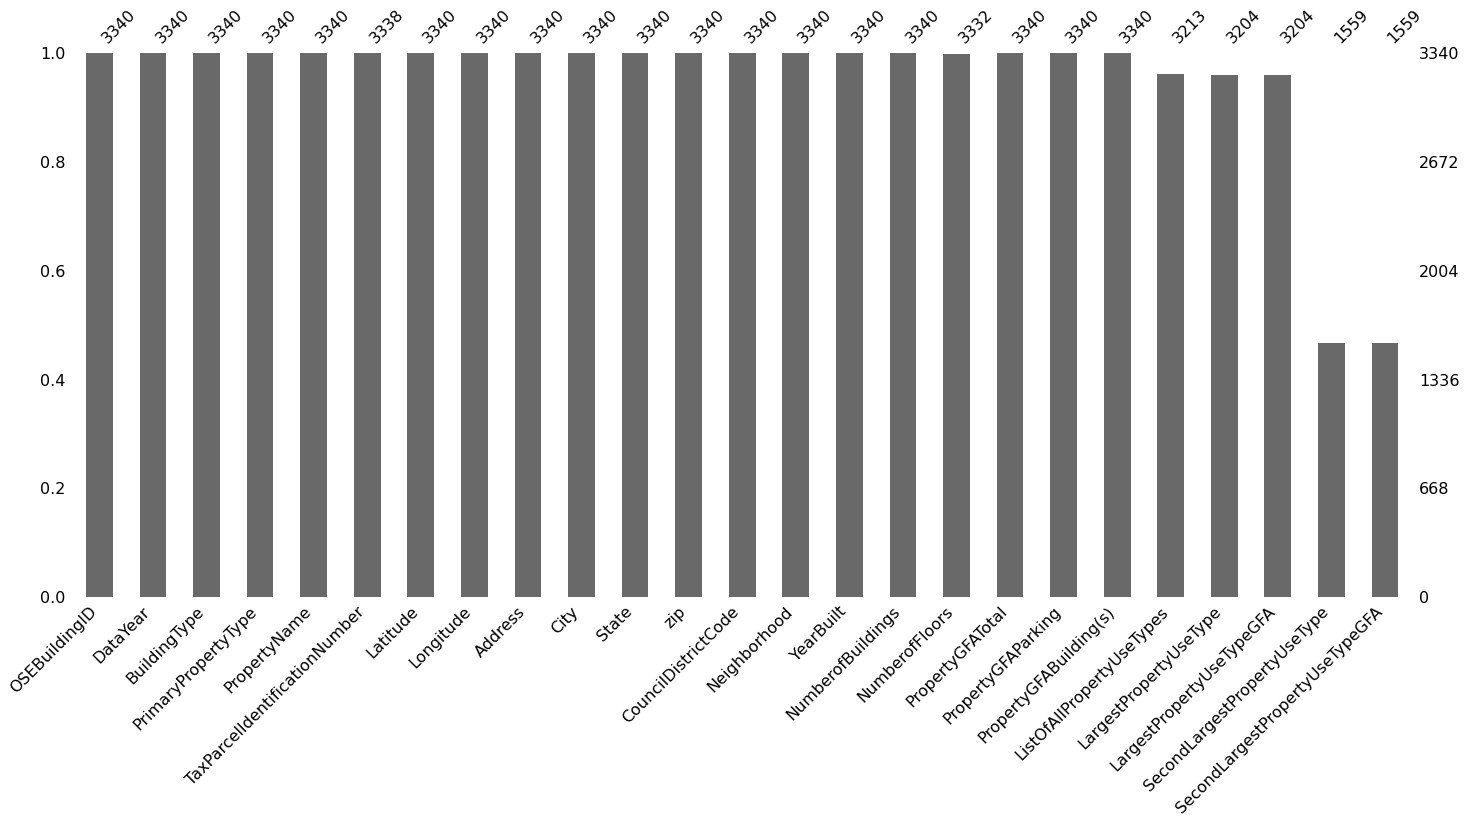

In [1385]:
data2015 = data[data.DataYear==2015] 
msno.bar(data2015[data2015.columns[:25]])

<AxesSubplot:>

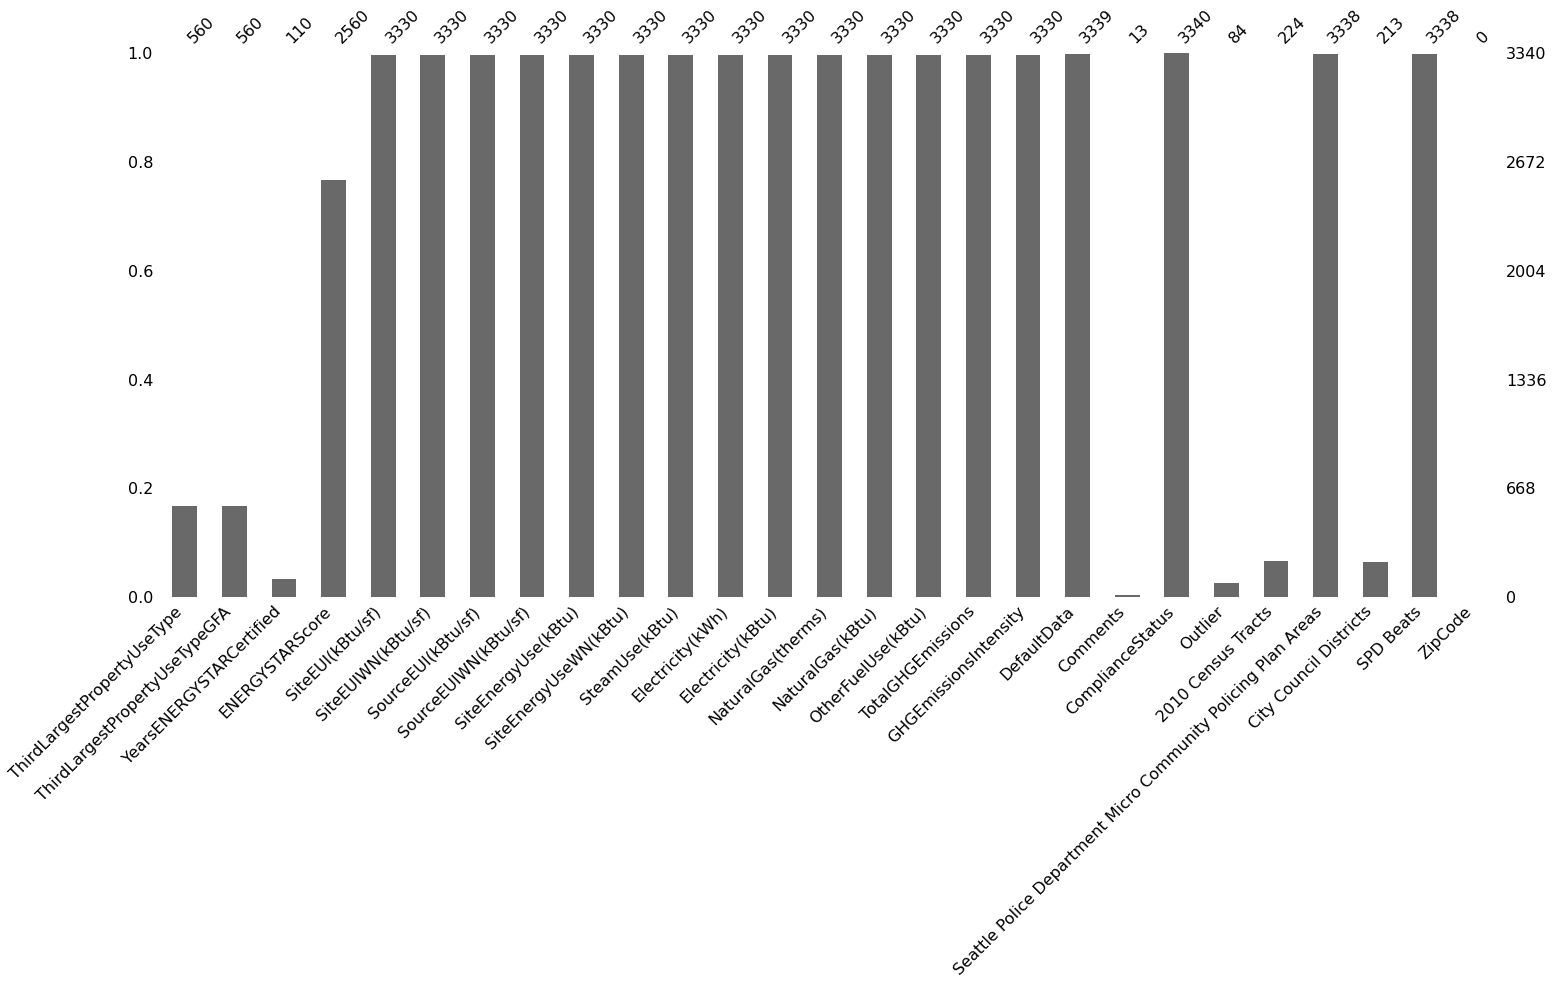

In [1386]:
msno.bar(data2015[data2015.columns[25:]])

In [1387]:
missing = data2015.notna().sum()/data2015.shape[0]
missing.sort_values(ascending=False)

OSEBuildingID                                                    1.000000
Longitude                                                        1.000000
City                                                             1.000000
State                                                            1.000000
zip                                                              1.000000
CouncilDistrictCode                                              1.000000
Neighborhood                                                     1.000000
YearBuilt                                                        1.000000
NumberofBuildings                                                1.000000
PropertyGFATotal                                                 1.000000
PropertyGFAParking                                               1.000000
PropertyGFABuilding(s)                                           1.000000
Latitude                                                         1.000000
Address                               

<AxesSubplot:>

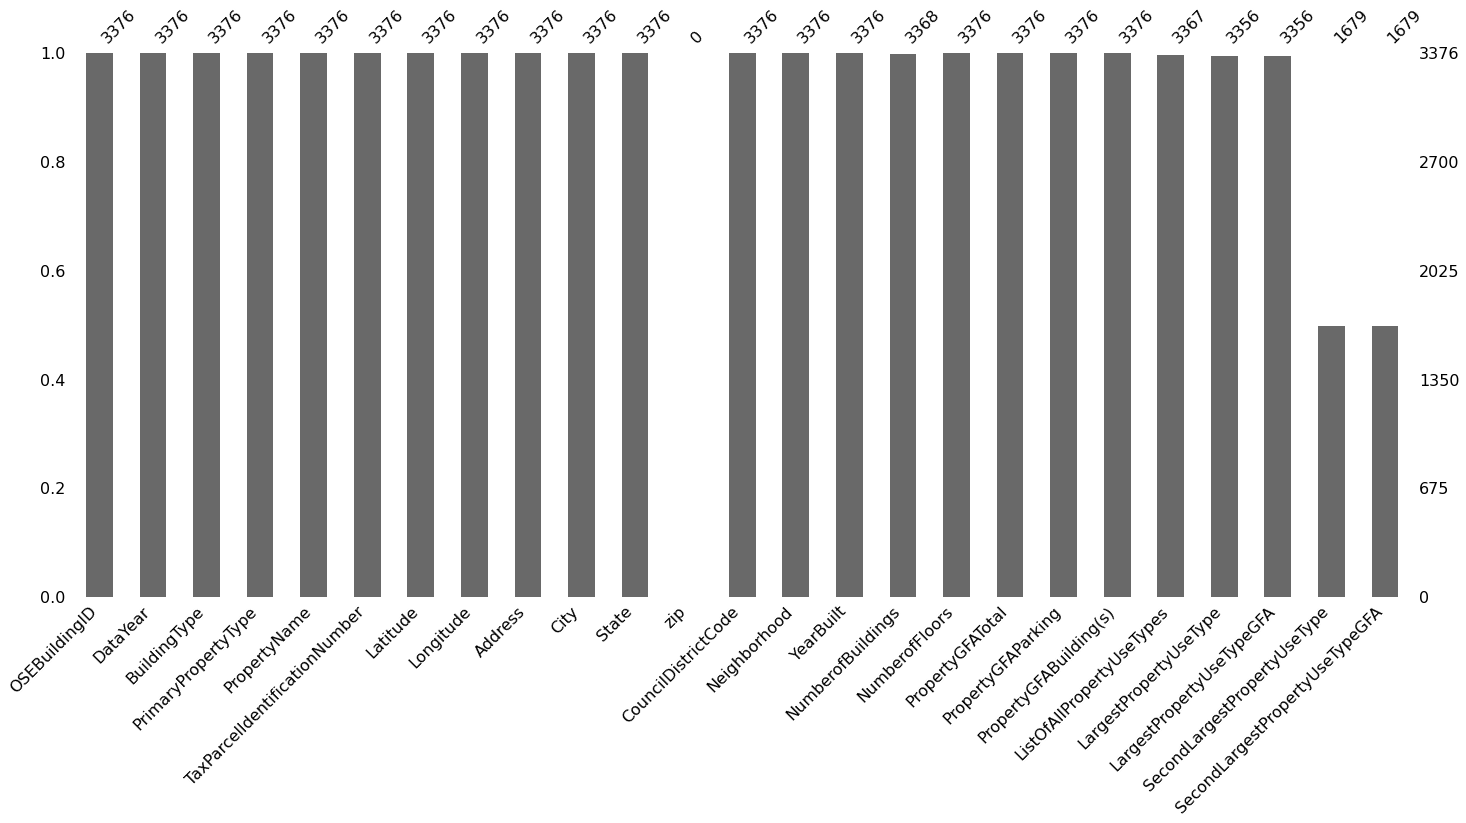

In [1388]:
data2016 = data[data.DataYear==2016] 
msno.bar(data2016[data2016.columns[:25]])

In [1389]:
missing = data2016.notna().sum()/data2016.shape[0]
missing.sort_values(ascending=False)

OSEBuildingID                                                    1.000000
NumberofFloors                                                   1.000000
PropertyGFAParking                                               1.000000
PropertyGFABuilding(s)                                           1.000000
YearBuilt                                                        1.000000
Neighborhood                                                     1.000000
CouncilDistrictCode                                              1.000000
State                                                            1.000000
City                                                             1.000000
Address                                                          1.000000
Longitude                                                        1.000000
PropertyGFATotal                                                 1.000000
TaxParcelIdentificationNumber                                    1.000000
DataYear                              

On supprime les colonnes remplies à moins de 50%

In [1390]:
missing = data.notna().sum()/data.shape[0]
missing[missing<0.5]

zip                                                              0.497320
SecondLargestPropertyUseType                                     0.482132
SecondLargestPropertyUseTypeGFA                                  0.482132
ThirdLargestPropertyUseType                                      0.172126
ThirdLargestPropertyUseTypeGFA                                   0.172126
YearsENERGYSTARCertified                                         0.034098
OtherFuelUse(kBtu)                                               0.495831
Comments                                                         0.001936
Outlier                                                          0.017272
2010 Census Tracts                                               0.033353
Seattle Police Department Micro Community Policing Plan Areas    0.497022
City Council Districts                                           0.031715
SPD Beats                                                        0.497022
dtype: float64

In [1391]:
data = data.drop(columns=missing[missing<0.5].index)

<AxesSubplot:>

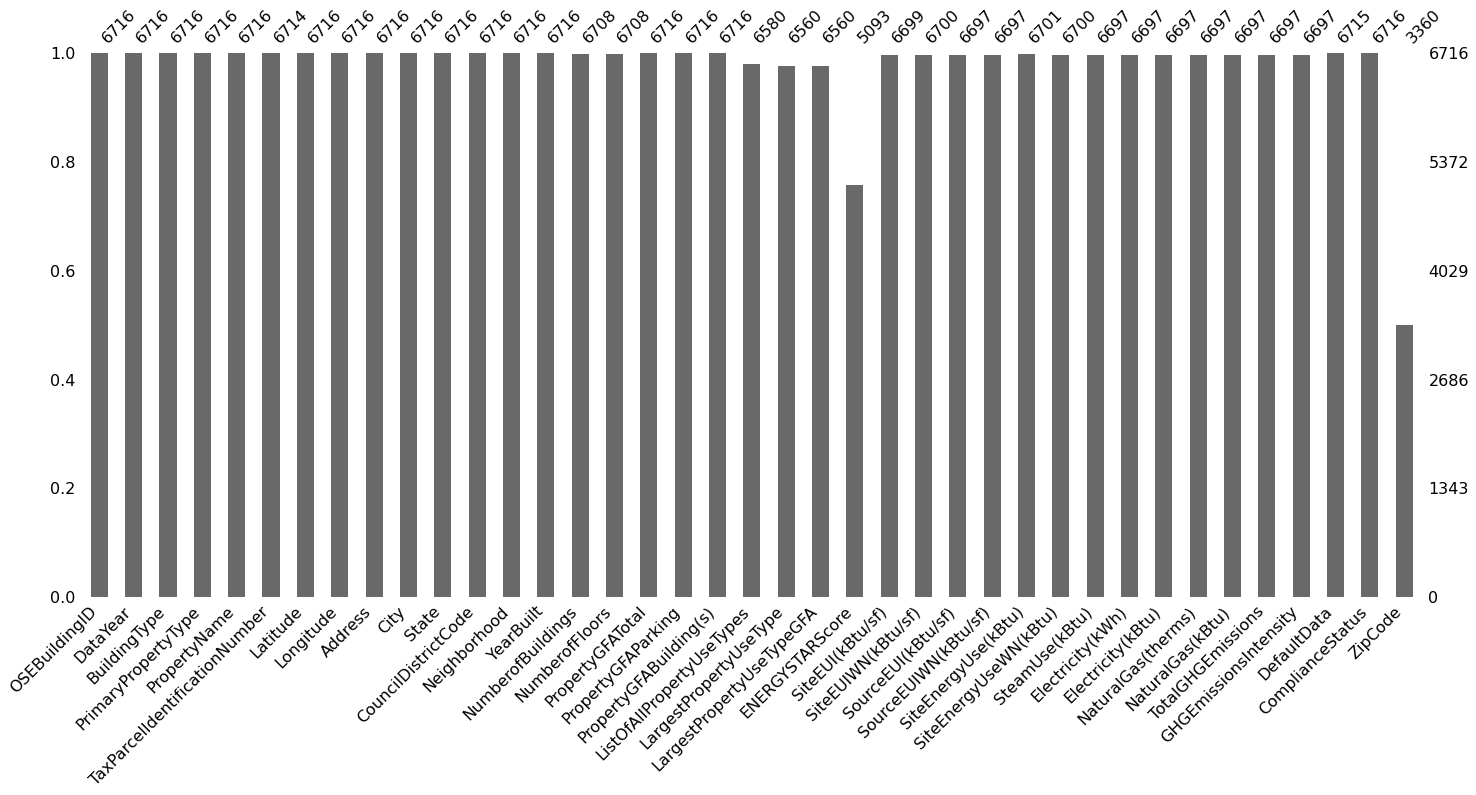

In [1392]:
msno.bar(data)

<AxesSubplot:>

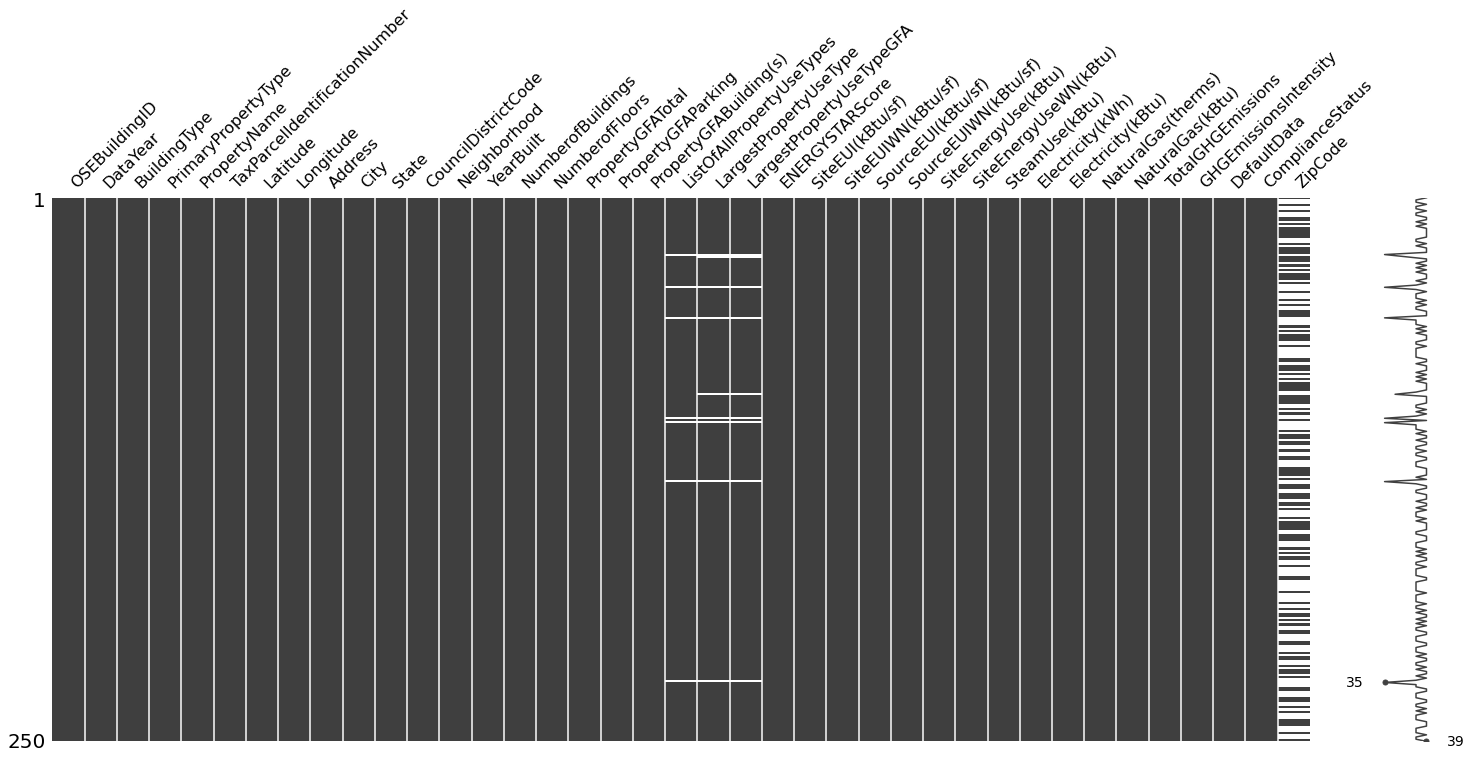

In [1393]:
data.dropna(subset=["ENERGYSTARScore"], how="any", inplace=True)
msno.matrix(data.sample(250))

<AxesSubplot:>

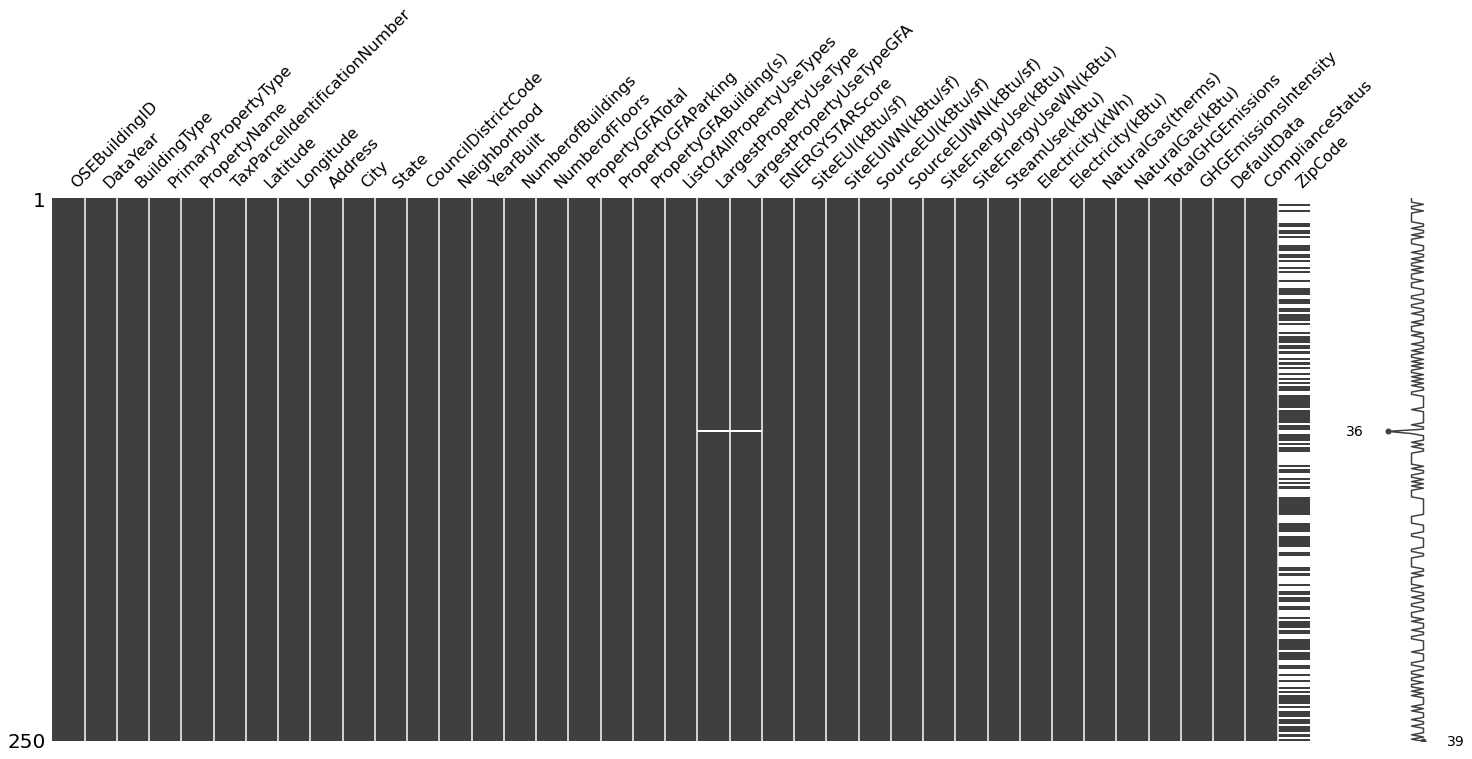

In [1394]:
data.dropna(subset=["ListOfAllPropertyUseTypes", 
                        "LargestPropertyUseType", 
                        "LargestPropertyUseTypeGFA"], how="all", inplace=True)

msno.matrix(data.sample(250))

In [1395]:
data.dropna(subset=[c for c in data.columns if c!="ZipCode"], how="any", inplace=True)

In [1396]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4972 entries, 0 to 3371
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  4972 non-null   int64  
 1   DataYear                       4972 non-null   int64  
 2   BuildingType                   4972 non-null   object 
 3   PrimaryPropertyType            4972 non-null   object 
 4   PropertyName                   4972 non-null   object 
 5   TaxParcelIdentificationNumber  4972 non-null   object 
 6   Latitude                       4972 non-null   object 
 7   Longitude                      4972 non-null   object 
 8   Address                        4972 non-null   object 
 9   City                           4972 non-null   object 
 10  State                          4972 non-null   object 
 11  CouncilDistrictCode            4972 non-null   int64  
 12  Neighborhood                   4972 non-null   o

In [1397]:
data.to_csv("data.csv", index_label=False)

# II. Analyse exploratoire

In [1398]:
data = pd.read_csv("./data.csv")

## II.1 Variables qualitatives et variables quantitatives

**On sépare le dataframe en deux: les colonnes numériques et les colonnes "object"**

In [1399]:
mask = data.dtypes!="object"
numerical_features = mask_numeric[mask_numeric].index
numerical_features

Index(['OSEBuildingID', 'DataYear', 'Latitude', 'Longitude',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ZipCode'],
      dtype='object')

In [1400]:
mask = data.dtypes=="object"
categorical_features = mask[mask].index
categorical_features

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'Address', 'City', 'State',
       'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'DefaultData', 'ComplianceStatus'],
      dtype='object')

**On retire les colonnes OSEBuildingID, DataYear, CouncilDistrictCode, YearBuilt, Latitude, Longitude, ZipCode qui sont des variables catégorielles en réalité**

In [1401]:
num_categorical = pd.Index(["OSEBuildingID", 
                 "DataYear", 
                 "CouncilDistrictCode", 
                 "YearBuilt", 
                 "Latitude",
                 "Longitude", 
                 "ZipCode"])

In [1402]:
# On récupère ces colonnes dans la liste des indicateurs catégoriels
categorical_features = categorical_features.append(num_categorical)
categorical_features

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'Address', 'City', 'State',
       'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'DefaultData', 'ComplianceStatus', 'OSEBuildingID', 'DataYear',
       'CouncilDistrictCode', 'YearBuilt', 'Latitude', 'Longitude', 'ZipCode'],
      dtype='object')

In [1403]:
# On crée l'index quantitative_features qui ne contient que les variables quantitatives
quantitative_features = pd.Index([c for c in numerical_features if c not in categorical_features])
quantitative_features

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

## II.2 Variables quantitatives

On souhaite se passer des relevés annuels. On doit donc arriver à faire des prédictions sur les variables "targets" sans les variables "SiteEUI, SiteEUIWN, SourceEUI, SourceEUIWN, SiteEnergyUseWN, SteamUse, Electricity, NaturalGas, GHGEmissionsIntensity".

In [1404]:
# On exclut les indicateurs liés à l'énergie consommée dans la liste des indicateurs quantitatifs
quantitative_features = pd.Index(['NumberofBuildings',
                    'NumberofFloors', 
                    'PropertyGFATotal',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)',
                    'LargestPropertyUseTypeGFA'])
targets = pd.Index(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"])

### II.2.1 Distribution des variables quantitatives

In [1406]:
for feat_idx, feat in enumerate(quantitative_features.append(targets)):
    print(feat_idx, feat)

0 NumberofBuildings
1 NumberofFloors
2 PropertyGFATotal
3 PropertyGFAParking
4 PropertyGFABuilding(s)
5 LargestPropertyUseTypeGFA
6 TotalGHGEmissions
7 SiteEnergyUse(kBtu)


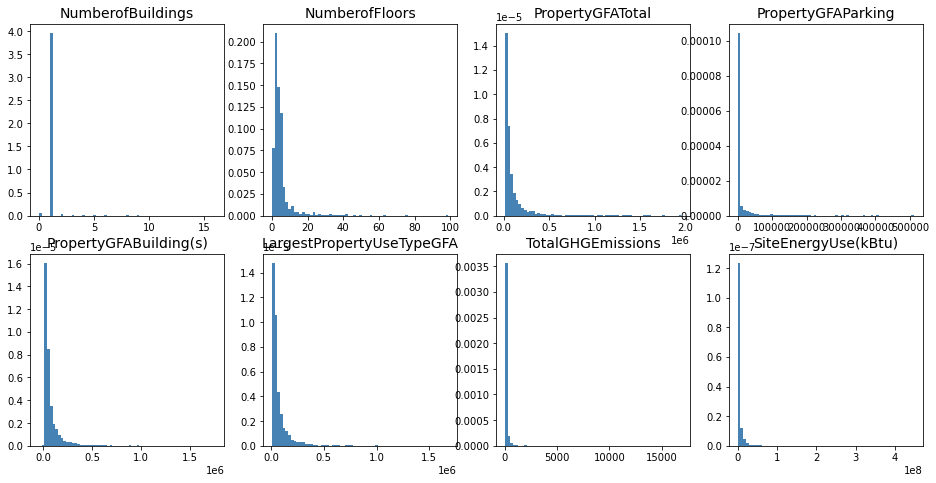

In [1408]:
fig = plt.figure(figsize=(16, 12))
for feat_idx, feat in enumerate(quantitative_features.append(targets)):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(data[feat], bins=5*int(1+np.log2(data.shape[0])), color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(feat, fontsize=14)

Données très dispersées. Echelles très différentes d'une variable à l'autre. On a des outliers.

### II.2.2 outliers

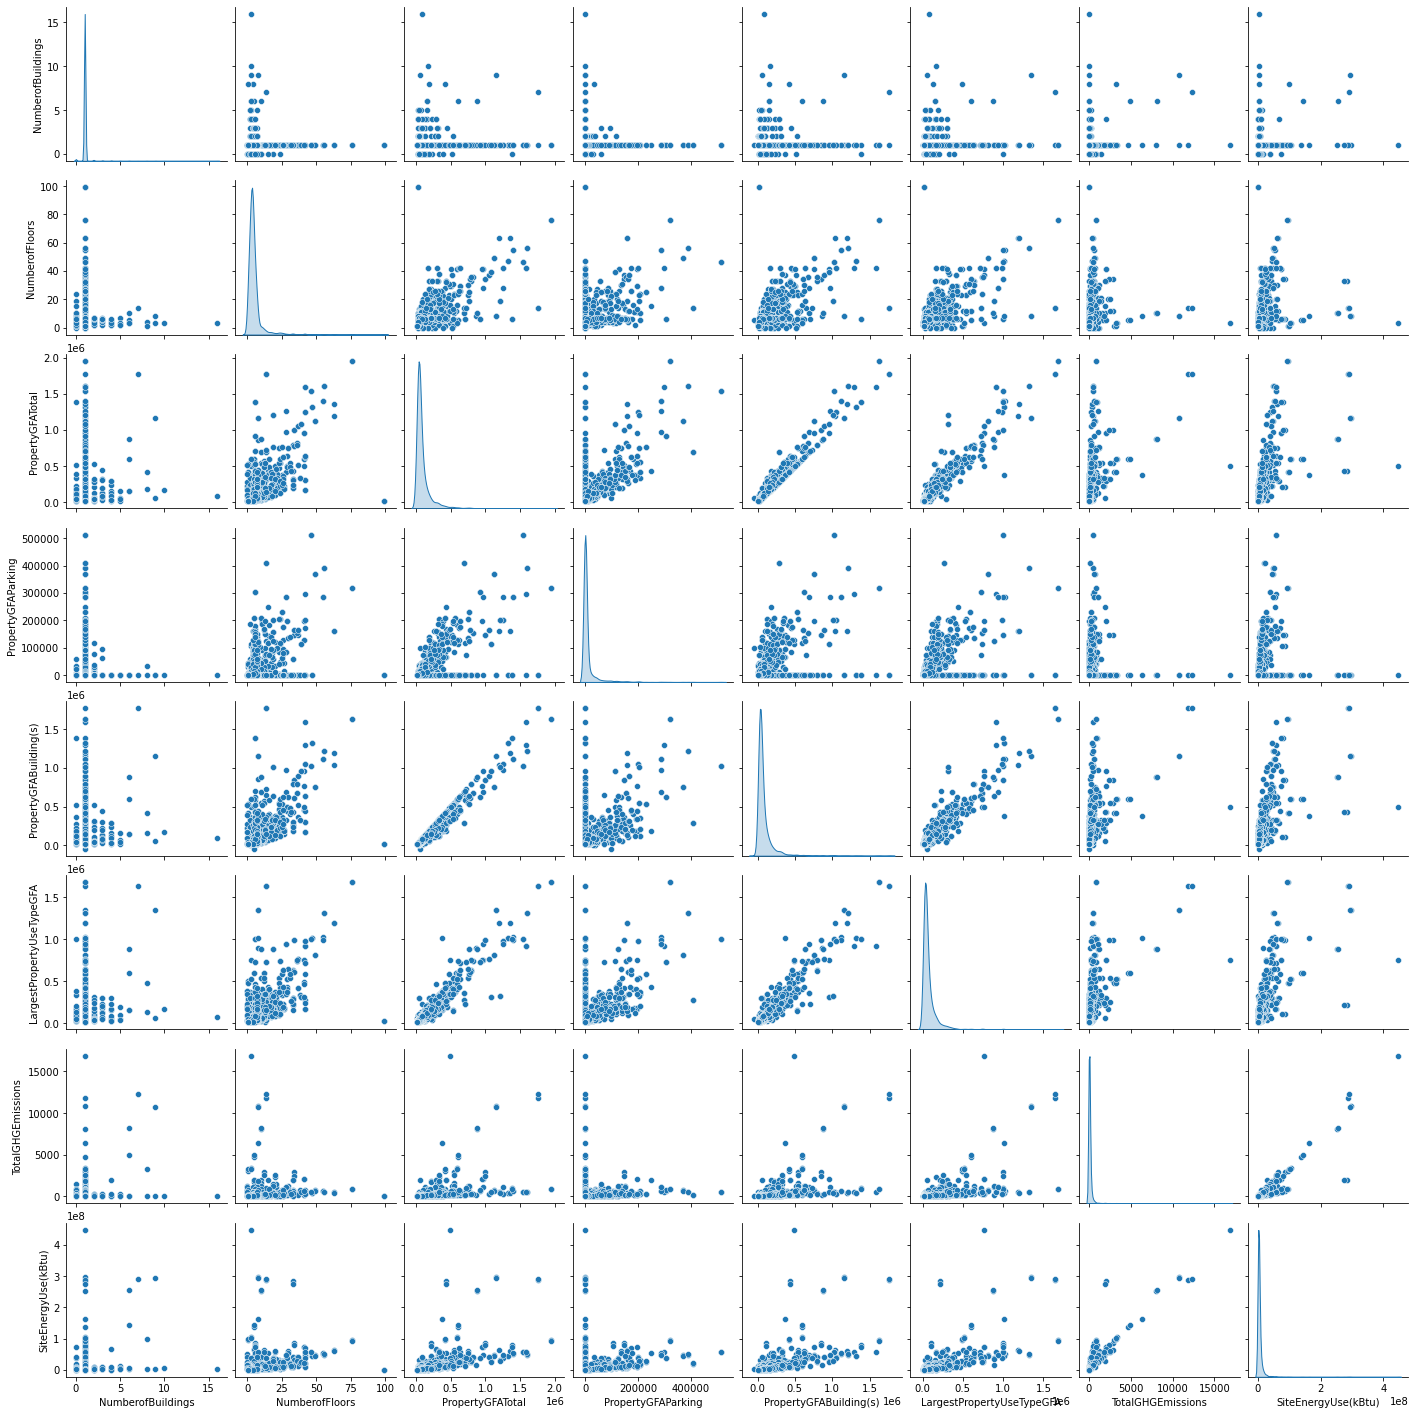

In [1409]:
sns.pairplot(data[quantitative_features.append(targets)], diag_kind="kde")

Outliers dans NumberofBuildings, NumberofFloors, TotalGHGEmissions, SiteEnergyUse(kBtu)

In [1173]:
# On exclut les outliers
data = data[data.NumberofFloors<data.NumberofFloors.quantile(0.99)]
data = data[data["NumberofBuildings"]<data["NumberofBuildings"].quantile(0.99)]
data = data[data["TotalGHGEmissions"]<data["TotalGHGEmissions"].quantile(0.99)]
data = data[data["SiteEnergyUse(kBtu)"]<data["SiteEnergyUse(kBtu)"].quantile(0.99)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747 entries, 0 to 3371
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  4747 non-null   int64  
 1   DataYear                       4747 non-null   int64  
 2   BuildingType                   4747 non-null   object 
 3   PrimaryPropertyType            4747 non-null   object 
 4   PropertyName                   4747 non-null   object 
 5   TaxParcelIdentificationNumber  4747 non-null   object 
 6   Latitude                       4747 non-null   float64
 7   Longitude                      4747 non-null   float64
 8   Address                        4747 non-null   object 
 9   City                           4747 non-null   object 
 10  State                          4747 non-null   object 
 11  CouncilDistrictCode            4747 non-null   int64  
 12  Neighborhood                   4747 non-null   o

<AxesSubplot:>

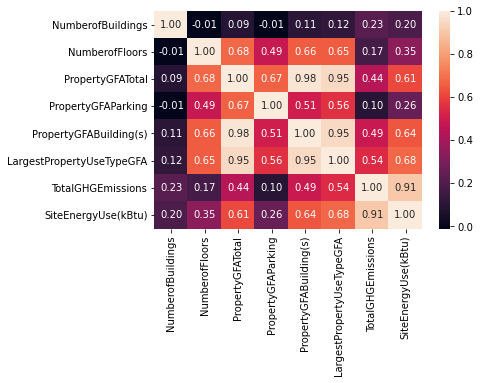

In [1477]:
corr = data[quantitative_features.append(targets)].corr()
sns.heatmap(corr, annot=True, fmt=".2f")

PropertyGFATotal semble être la somme de PropertyGFAParking et PropertyGFABuilding(s).

<AxesSubplot:ylabel='PropertyGFATotal'>

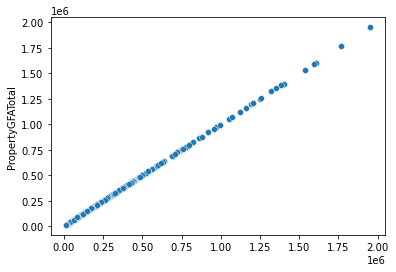

In [1478]:
sum_pgfa = data.loc[:, ["PropertyGFABuilding(s)", "PropertyGFAParking"]].apply(np.sum, axis=1)
tot_pgfa = data.PropertyGFATotal

sns.scatterplot(x=sum_pgfa, y=tot_pgfa)

On n'utilisera pas PropertyGFATotal

In [1479]:
data.drop(columns="PropertyGFATotal", inplace=True)

In [1480]:
quantitative_features = quantitative_features.drop("PropertyGFATotal")

Pour chaque target, on va trier les variables de la plus corrélée à la moins corrélée

In [1481]:
data[quantitative_features.append(targets)].corr()["TotalGHGEmissions"].sort_values(ascending=False)

TotalGHGEmissions            1.000000
SiteEnergyUse(kBtu)          0.906259
LargestPropertyUseTypeGFA    0.543581
PropertyGFABuilding(s)       0.487503
NumberofBuildings            0.225789
NumberofFloors               0.174598
PropertyGFAParking           0.099883
Name: TotalGHGEmissions, dtype: float64

In [1482]:
data[quantitative_features.append(targets)].corr()["SiteEnergyUse(kBtu)"].sort_values(ascending=False)

SiteEnergyUse(kBtu)          1.000000
TotalGHGEmissions            0.906259
LargestPropertyUseTypeGFA    0.676763
PropertyGFABuilding(s)       0.642293
NumberofFloors               0.346497
PropertyGFAParking           0.259088
NumberofBuildings            0.195306
Name: SiteEnergyUse(kBtu), dtype: float64

In [1215]:
# On va travailler sur chacun des jeux de données séparément.
df2015 = data[data.DataYear==2015]
df2015.index = pd.Index(range(0, df2015.shape[0]))
df2016 = data[data.DataYear==2016]
df2016.index = pd.Index(range(0, df2016.shape[0]))

### II.3 Variables catégorielles

### II.3.1 Etude des corrélations

In [1325]:
cat_feats = pd.DataFrame(data={"name":categorical_features, "nombre de modalités":data_nna[categorical_features].nunique()})
cat_feats

,name,nombre de modalités
BuildingType,BuildingType,7
PrimaryPropertyType,PrimaryPropertyType,25
PropertyName,PropertyName,4852
TaxParcelIdentificationNumber,TaxParcelIdentificationNumber,2846
Address,Address,4766
City,City,2
State,State,1
Neighborhood,Neighborhood,18
ListOfAllPropertyUseTypes,ListOfAllPropertyUseTypes,238
LargestPropertyUseType,LargestPropertyUseType,26


Variables d'intérêt: BuildingType, PrimaryPropertyType, LargestPropertyUseType, YearBuilt

In [1326]:
data.BuildingType.head()

0    NonResidential
1    NonResidential
4    NonResidential
6    NonResidential
8    NonResidential
Name: BuildingType, dtype: object

In [1265]:
data.LargestPropertyUseType.head()

0    Hotel
1    Hotel
4    Hotel
6    Hotel
8    Hotel
Name: LargestPropertyUseType, dtype: object

In [1266]:
data.PrimaryPropertyType.head()

0    Hotel
1    Hotel
4    Hotel
6    Hotel
8    Hotel
Name: PrimaryPropertyType, dtype: object

In [1327]:
data.YearBuilt.head()

0    1927
1    1996
4    1980
6    1926
8    1904
Name: YearBuilt, dtype: int64

Doublons entre LargestPropertyUseType et PrimaryPropertyType?

In [1305]:
data.LargestPropertyUseType.unique()

array(['Hotel', 'Multifamily Housing', 'K-12 School',
       'Self-Storage Facility', 'Office', 'Senior Care Community',
       'Medical Office', 'Retail Store', 'Residence Hall/Dormitory',
       'Financial Office', 'Non-Refrigerated Warehouse',
       'Worship Facility', 'Supermarket/Grocery Store',
       'Distribution Center', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Public Services', 'Bank Branch',
       'Parking', 'Laboratory', 'Manufacturing/Industrial Plant',
       'Hospital (General Medical & Surgical)', 'Other - Restaurant/Bar',
       'Other'], dtype=object)

In [1306]:
data.PrimaryPropertyType.unique()

array(['Hotel', 'Mid-Rise Multifamily', 'K-12 School',
       'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
       'Large Office', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Retail Store', 'Residence Hall/Dormitory',
       'Other', 'Non-Refrigerated Warehouse', 'Worship Facility',
       'Supermarket/Grocery Store', 'Mixed Use Property',
       'Distribution Center\n', 'Refrigerated Warehouse',
       'High-Rise Multifamily', 'Hospital', 'Residence Hall', 'Warehouse',
       'Supermarket / Grocery Store', 'Distribution Center', 'Office'],
      dtype=object)

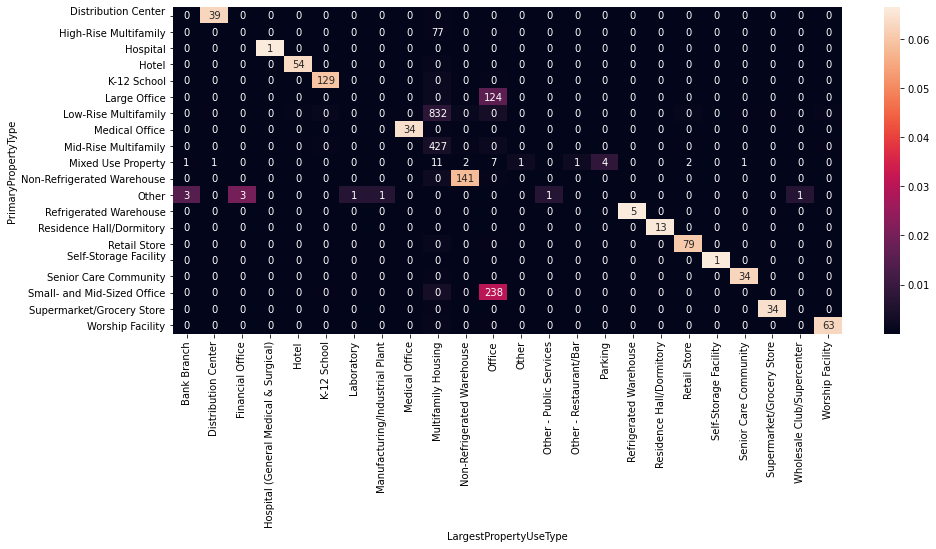

In [1332]:
def contingence(Var1, Var2, df):
    X=Var1
    Y=Var2
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = measure/xi_n
    plt.figure(figsize=(15, 6))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")

contingence("PrimaryPropertyType", "LargestPropertyUseType", df2015)

Les variables PrimaryPropertyType et LargestPropertyUseType sont très semblables. On ne choisit que l'une de ces deux variables dans un premier temps.

On va grouper les YearBuilt par décennies

In [1350]:
slice = 10 # décennies
bins = [1900+i*slice for i in range(13)]
yb_grouped = np.digitize(data.YearBuilt, bins)
yb_grouped = pd.Series(data=yb_grouped, name="yb_grouped")

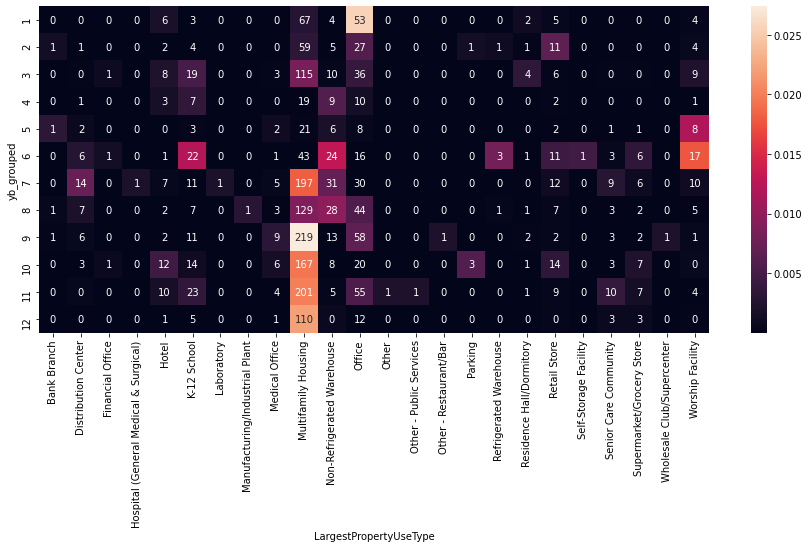

In [1352]:
df1 = pd.concat([df2015, yb_grouped], axis=1)
contingence("yb_grouped", "LargestPropertyUseType", df1)

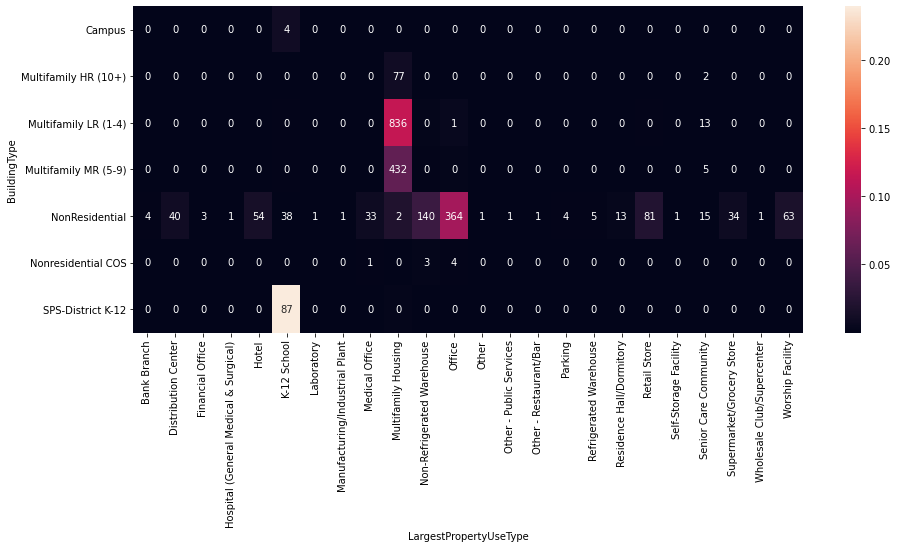

In [1353]:
contingence("BuildingType", "LargestPropertyUseType", df1)

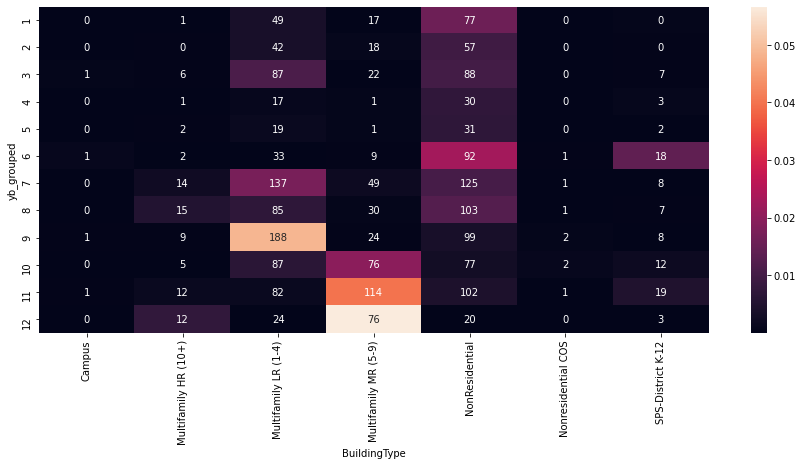

In [1427]:
contingence("yb_grouped", "BuildingType" , df1)

In [1339]:
# On regroupe TotalGHGEmissions en 10 catégories
deciles = df2015["TotalGHGEmissions"].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# On groupe TotalGHGEmissions en 10 catégories
bins = deciles[4:-1].to_numpy()
cat_TotalGHG = np.digitize(df2015.TotalGHGEmissions, bins)

# Création d'une Series pour pouvoir concatener
cat_TotalGHG = pd.Series(data=cat_TotalGHG, name="cat_TotalGHG", index=range(0, cat_TotalGHG.shape[0]))

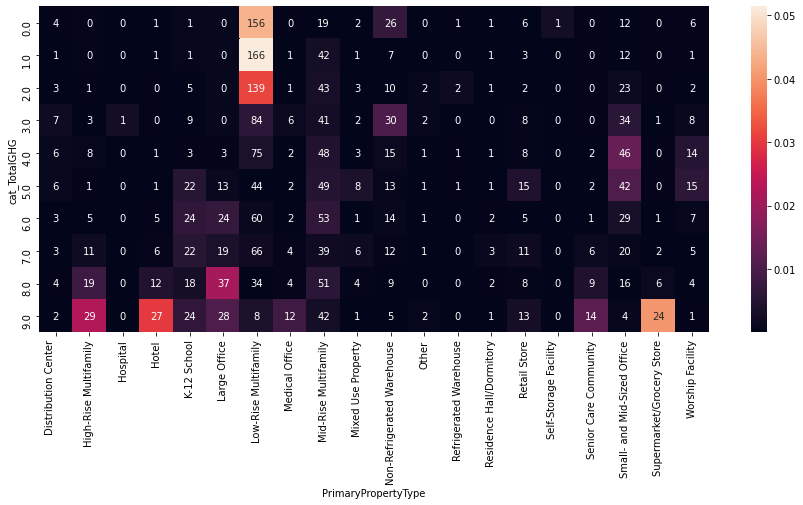

In [1356]:
df1 = pd.concat([df1, cat_TotalGHG], axis=1)

contingence("cat_TotalGHG", "PrimaryPropertyType", df1)

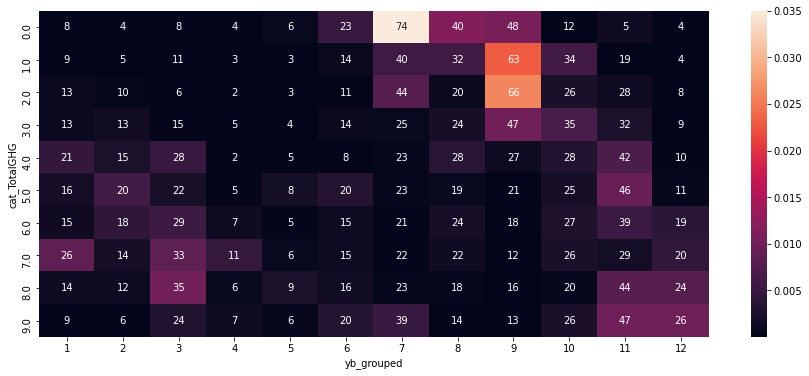

In [1357]:
contingence("cat_TotalGHG", "yb_grouped", df1)

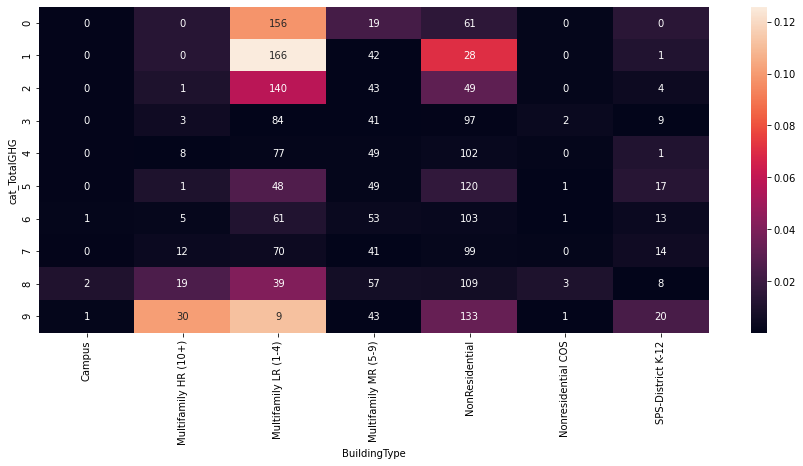

In [1346]:
contingence("cat_TotalGHG", "BuildingType", df1)

On ne fait pas mieux qu'avec PrimaryPropertyType seul. On vérifie sur 2016 avant d'aller plus loin

# III Régressions linéaires

## III.1 Régression linéaire simple sur les variables quantitatives

In [1432]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

1. D'abord avec LargestPropertyUseTypeGFA

In [1463]:
type("LargestPropertyUseTypeGFA")

str

In [1467]:
def print_cvs(var, target, df):
    try:
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        X = df[var].to_numpy().reshape(-1, 1)
    y = df[target].to_numpy()
    lr = LinearRegression()
    cvs = cross_val_score(lr, X, y, cv=10)
    print(cvs, "score moyen: {:.2f}".format(np.mean(cvs)), "meilleur score: {:.2f}".format(np.max(cvs)))
    
print_cvs("LargestPropertyUseTypeGFA", "TotalGHGEmissions", df2015)

[-0.13749062  0.16040715  0.33847489  0.28149821  0.46243567  0.25762784
  0.22604207  0.22825885  0.2498296   0.25233874] score moyen: 0.23 meilleur score: 0.46


In [1468]:
print_cvs("LargestPropertyUseTypeGFA", "SiteEnergyUse(kBtu)", df2015)

[0.33637065 0.25802836 0.53861827 0.50940157 0.58339803 0.42159265
 0.39386284 0.45041454 0.49941291 0.41617466] score moyen: 0.44 meilleur score: 0.58


2. LargestPropertyUseTypeGFA, PropertyGFABuilding(s)

In [1469]:
print_cvs(["LargestPropertyUseTypeGFA", "PropertyGFABuilding(s)"], "TotalGHGEmissions", df2015)

[-0.11817267  0.16888588  0.35325649  0.28928169  0.46566059  0.27394443
  0.22005538  0.19039726  0.23435394  0.28070183] score moyen: 0.24 meilleur score: 0.47


In [1471]:
print_cvs(["LargestPropertyUseTypeGFA", "PropertyGFABuilding(s)"], "SiteEnergyUse(kBtu)", df2015)

[0.36843704 0.27511961 0.59326547 0.52613284 0.58341989 0.45865905
 0.38379931 0.37155268 0.54247657 0.43818127] score moyen: 0.45 meilleur score: 0.59


3. LargestPropertyUseTypeGFA, PropertyGFABuilding(s), NumberofBuildings, NumberofFloors, PropertyGFAParking

In [1472]:
print_cvs(["LargestPropertyUseTypeGFA",  
           "PropertyGFABuilding(s)",
           "NumberofBuildings", 
           "NumberofFloors",
           "PropertyGFAParking"], "TotalGHGEmissions", df2015)

[-0.10998622  0.14430472  0.36672162  0.30055116  0.46519456  0.26617005
  0.22040085  0.19761895  0.23940865  0.28622429] score moyen: 0.24 meilleur score: 0.47


In [1473]:
print_cvs(["LargestPropertyUseTypeGFA",  
           "PropertyGFABuilding(s)",
           "NumberofBuildings", 
           "NumberofFloors",
           "PropertyGFAParking"], "SiteEnergyUse(kBtu)", df2015)

[0.4197221  0.30891358 0.61398428 0.52089574 0.61264916 0.44238437
 0.32864238 0.37849935 0.54717334 0.45547334] score moyen: 0.46 meilleur score: 0.61


### III.2 Régression linéaire simple avec toutes les variables

In [1483]:
# On ne garde que les variables pertinentes
buildingtypes = pd.get_dummies(df2015.BuildingType, drop_first=True)
largestptype = pd.get_dummies(df2015.LargestPropertyUseType, drop_first=True)
#primaryptype = pd.get_dummies(df2015.PrimaryPropertyType, drop_first=True)
yearbuilt = pd.get_dummies(df2015.YearBuilt, drop_first=True)

cat_df = pd.concat([buildingtypes, largestptype, yearbuilt], axis=1) 
d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)

In [1484]:
features = pd.Index([c for c in d2015.columns if c not in targets])
features

Index([        'NumberofBuildings',            'NumberofFloors',
              'PropertyGFAParking',    'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA',      'Multifamily HR (10+)',
            'Multifamily LR (1-4)',      'Multifamily MR (5-9)',
                  'NonResidential',        'Nonresidential COS',
       ...
                              2006,                        2007,
                              2008,                        2009,
                              2010,                        2011,
                              2012,                        2013,
                              2014,                        2015],
      dtype='object', length=144)

In [1486]:
print_cvs(features, "TotalGHGEmissions", d2015)

[0.11526386 0.30149335 0.34497445 0.38702861 0.58701962 0.38114679
 0.2806381  0.50413128 0.35723662 0.40823483] score moyen: 0.37 meilleur score: 0.59


In [1487]:
print_cvs(features, "SiteEnergyUse(kBtu)", d2015)

[0.55727338 0.49886209 0.58215975 0.52819791 0.77204756 0.56694284
 0.46641722 0.65231814 0.69310773 0.72899673] score moyen: 0.60 meilleur score: 0.77


Cette fois avec PrimaryPropertyType

In [1488]:
# On ne garde que les variables pertinentes
buildingtypes = pd.get_dummies(df2015.BuildingType, drop_first=True)
#largestptype = pd.get_dummies(df2015.LargestPropertyUseType, drop_first=True)
primaryptype = pd.get_dummies(df2015.PrimaryPropertyType, drop_first=True)
yearbuilt = pd.get_dummies(df2015.YearBuilt, drop_first=True)

cat_df = pd.concat([buildingtypes, primaryptype, yearbuilt], axis=1) 
d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)

In [1489]:
features = pd.Index([c for c in d2015.columns if c not in targets])
features

Index([        'NumberofBuildings',            'NumberofFloors',
              'PropertyGFAParking',    'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA',      'Multifamily HR (10+)',
            'Multifamily LR (1-4)',      'Multifamily MR (5-9)',
                  'NonResidential',        'Nonresidential COS',
       ...
                              2006,                        2007,
                              2008,                        2009,
                              2010,                        2011,
                              2012,                        2013,
                              2014,                        2015],
      dtype='object', length=140)

In [1490]:
print_cvs(features, "TotalGHGEmissions", d2015)

[0.10941524 0.28671245 0.33288031 0.37796073 0.58363969 0.36483433
 0.27928921 0.48141111 0.35820548 0.42809026] score moyen: 0.36 meilleur score: 0.58


In [1491]:
print_cvs(features, "SiteEnergyUse(kBtu)", d2015)

[0.58551834 0.53204518 0.57516645 0.51449323 0.76551657 0.5951122
 0.49446901 0.64762271 0.7081261  0.74646356] score moyen: 0.62 meilleur score: 0.77


PrimaryPropertyType semble donner de légèrement meilleurs résultats pour la prédiction de SiteEnergyUse(kBtu)

## III.3 RidgeCV

In [1502]:
def print_ridgecv(var, targets, df, alphas, score):
    try:
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        X = df[var].to_numpy().reshape(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )

    param_grid = {'alpha':alphas}

    # Créer une regression Ridgeavec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    Ridge(), # une régression Ridge
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
    )

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train, y_train)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    

# Valeurs possibles du paramètre alpha
alphas = np.logspace(-4, 4, 10)

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_ridgecv(features, "SiteEnergyUse(kBtu)", d2015, alphas, score)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.70606e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.18659e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.55816e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.70761e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.76394e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAl

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 2.782559402207126}

Sur le jeu de test : 0.745


In [1503]:
print_ridgecv(features, "TotalGHGEmissions", d2015, alphas, score)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.60239e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.0739e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.35866e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.81695e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.36133e-18): result may not be accurate.
  overwrite_a=True).T
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlg

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 2.782559402207126}

Sur le jeu de test : 0.721


# A suivre: Latitude, Longitude

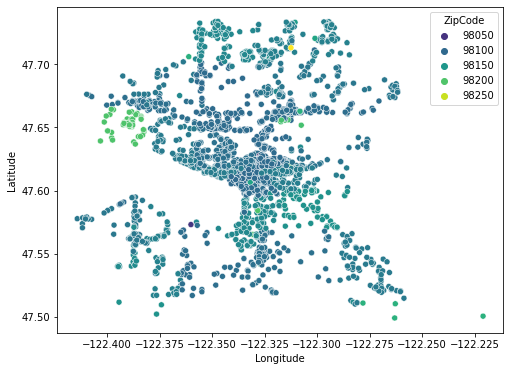

In [945]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Longitude', y="Latitude", data=data[data.ZipCode.notna()], hue="ZipCode", palette="viridis")
plt.show()

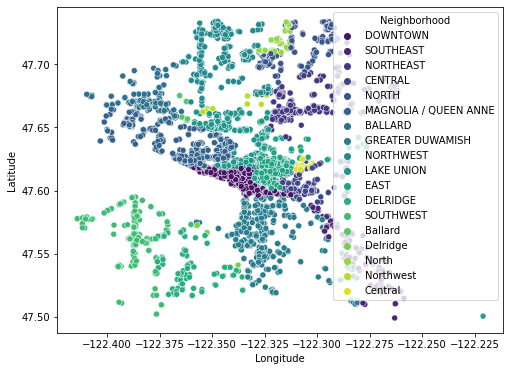

In [1027]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Longitude", y='Latitude', data=data, hue="Neighborhood", palette="viridis")
plt.show()

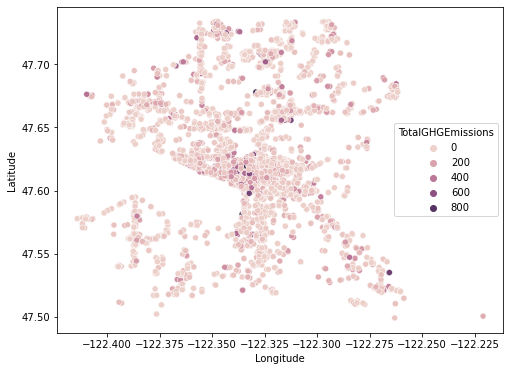

In [1025]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Longitude", y='Latitude', data=data, hue="TotalGHGEmissions")
plt.show()